In [1]:
%cd -q /home/dataproc
from inverted_index_gcp_new import InvertedIndex, MultiFileReader
from bm25 import BM_25
from backend import *
from search_fronted import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import json
import requests
import statistics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
     
with open('all_new.json', 'rt') as f:
  queries = json.load(f)

Evaluation Metrics

In [3]:
def recall_at_k(true_list, predicted_list, k=40):
    true_set = set(true_list)
    predicted_subset = predicted_list[:k]
    matches = [item for item in predicted_subset if item in true_set]
    return round(len(matches) / len(true_list), 3)

def precision_at_k(true_list, predicted_list, k=40):
    true_set = set(true_list)
    predicted_subset = predicted_list[:k]
    matches = len([item for item in predicted_subset if item in true_set])
    return round(matches / k, 3)

def r_precision(true_list, predicted_list):
    true_set = set(true_list)
    predicted_subset = predicted_list[:len(true_list)]
    matches = [item for item in predicted_subset if item in true_set]
    return round(len(matches) / len(true_list), 3)

def reciprocal_rank_at_k(true_list, predicted_list, k=40):
    true_set = set(true_list)
    predicted_subset = predicted_list[:k]
    for i, item in enumerate(predicted_subset):
        if item in true_set:
            return round(1 / (i + 1), 3)
    return 0.000

def f_score(true_list,predicted_list,k=40):
    
    precision = precision_at_k(true_list,predicted_list,k)
    recall = recall_at_k(true_list,predicted_list,k)
    if precision == 0 and recall == 0:
      return 0
    else:
      return round((2 * precision * recall) / (precision + recall), 3)

def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

Test all queries with MAP

In [4]:
result = []
map_avg = []
sum_duration = 0
pred_wids = {}
map25 = True
duration_35 = True
for q, true_wids in tqdm(queries.items()):
    duration, ap = None, None
    t_start = time.time()
    search_all_q = search(q) 
    duration = time.time() - t_start
    pred = [i[0] for i in search_all_q]
    pred_wids[q] = pred
    if duration > 35: duration_35 = False
    sum_duration += duration
    ap = average_precision(true_wids, pred)
    map_avg.append(ap)
    result.append((q, duration, ap))
    
if builtins.sum(map_avg) / len(map_avg) < 0.25: map25 = False 

100%|██████████| 30/30 [01:43<00:00,  3.44s/it]


In [5]:
print("Duration for each query < 35s : " + str(duration_35))
print("MAP@40 > 0.25   : " + str(map25))
print("MAP@40: " + str(builtins.sum(map_avg) / len(map_avg)))
print("AVG Duration   : " + str(sum_duration/len(queries)) + "\n")


Duration for each query < 35s : True
MAP@40 > 0.25   : True
MAP@40: 0.7474333333333334
AVG Duration   : 3.43397970199585



In [6]:
pd.DataFrame.from_records(result, columns=['Query', 'duration', "average precision"])

,Query,duration,average precision
0,best marvel movie,5.473401,0.697
1,How do kids come to world?,10.135442,0.667
2,Information retrieval,2.936453,1.000
3,LinkedIn,0.357575,1.000
4,How to make coffee?,0.521258,0.967
5,Ritalin,0.432387,0.761
6,How to make wine at home?,4.616892,0.236
7,Most expensive city in the world,12.931974,0.812
8,India,1.713346,0.653
9,how to make money fast?,2.048232,0.793


recall@k 0.14893333333333333
precision@k 0.13000000000000003
f_score@k 0.13470000000000001
r-precision 0.14893333333333333
MRR@k 0.8735999999999999
MAP@k 0.7474333333333334


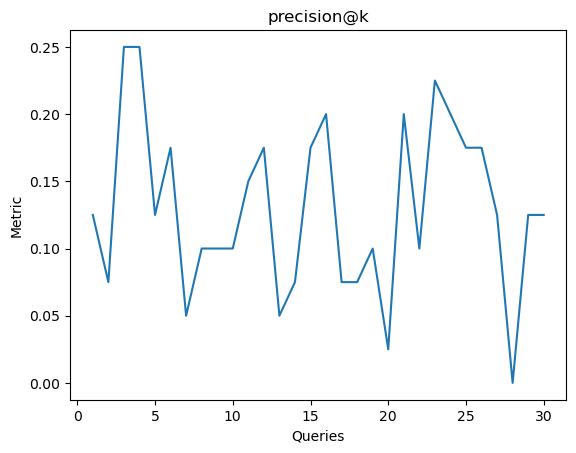

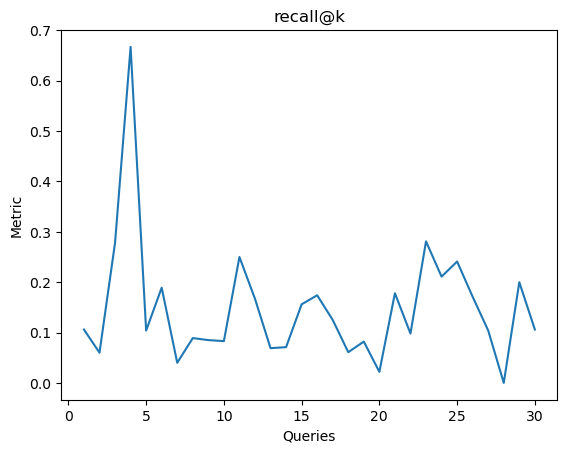

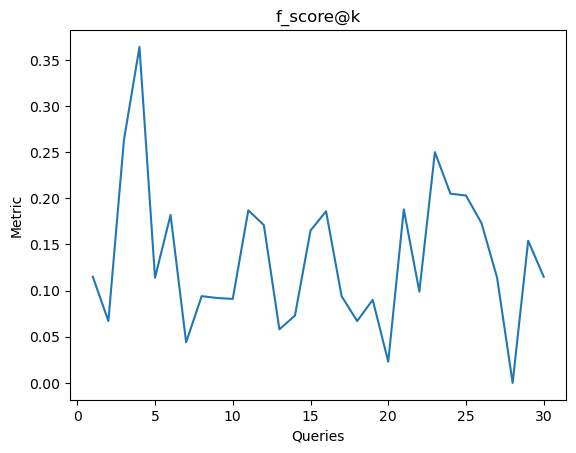

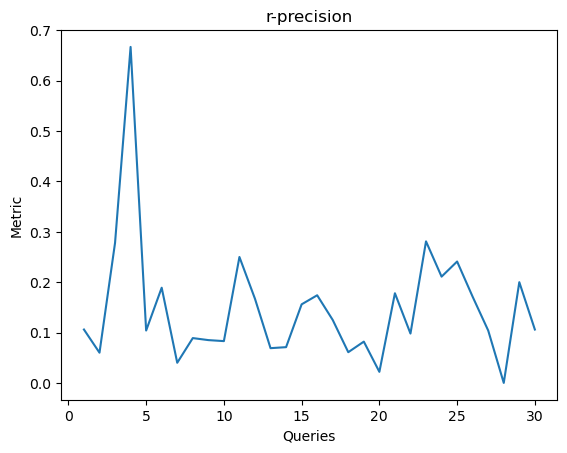

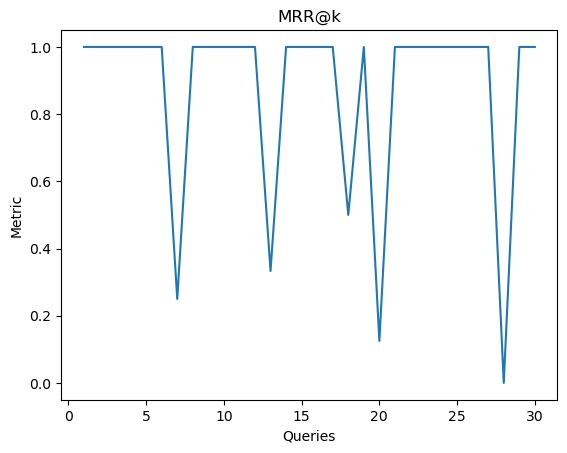

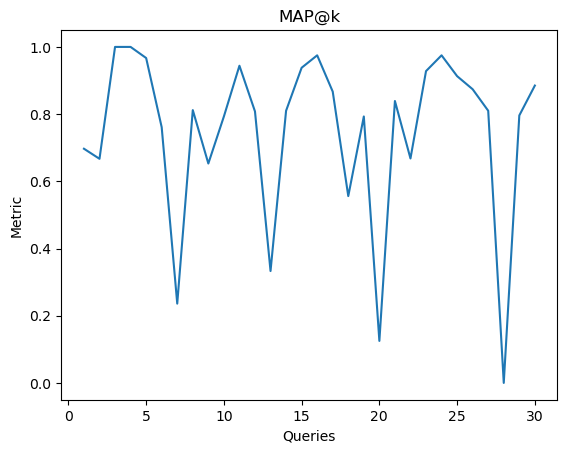

In [7]:
recall_lst, precision_lst, f_score_lst, r_precision_lst, reciprocal_rank_lst, avg_precision_lst = [], [], [], [], [], []
metrices = {'recall@k':recall_lst,
            'precision@k':precision_lst,
            'f_score@k': f_score_lst,
            'r-precision': r_precision_lst,
            'MRR@k':reciprocal_rank_lst,
            'MAP@k':avg_precision_lst}

for query, true in queries.items():  
    predicted = pred_wids[query]
    recall_lst.append(recall_at_k(true,predicted,k=40))
    precision_lst.append(precision_at_k(true,predicted,k=40))
    f_score_lst.append(f_score(true,predicted,k=40))
    r_precision_lst.append(r_precision(true,predicted))
    reciprocal_rank_lst.append(reciprocal_rank_at_k(true,predicted,k=40))
    avg_precision_lst.append(average_precision(true,predicted,k=40))

for name,values in metrices.items():
        print(name,sum(values)/len(values))

metrices_names = ['precision@k','recall@k','f_score@k','r-precision','MRR@k','MAP@k']
for metric_name in metrices_names:
    met = metrices
    met_list = met[metric_name]
    plt.xlabel("Queries")
    plt.ylabel("Metric")
    plt.title(metric_name)
    plt.plot([i+1 for i in range(len(met_list))], met_list)
    plt.show()


PAGE RANK RESEARCH

In [8]:
pr = get_pr()
sort_dic = sorted(list( pr.items()),key=lambda x: x[1])
values = list(pr.values())
num_of_pages =(len(values))
pstdev=statistics.pstdev(values)
variance = statistics.pvariance(values)
median = statistics.median(values)
Max_pr = max(pr.values())
Min_pr = min(pr.values())

print(f"number of pages: {num_of_pages}")
print(f"Max page rank is : {Max_pr} ")
print(f"Min page rank is : {Min_pr} ")
print(f"Median of page ranks is : {median}")
print(f"pstdev of page ranks is : {pstdev}")
print(f"variance of page ranks is : {variance}")
print(f"average of page rank is : {sum(values)/len(values)}")


number of pages: 6345849
Max page rank is : 9913.728782160773 
Min page rank is : 0.1501208493870428 
Median of page ranks is : 0.2515575284859403
pstdev of page ranks is : 12.414671512846478
variance of page ranks is : 154.12406877188187
average of page rank is : 1.0000000000249587


PAGE VIEW RESEARCH

In [3]:
pv = get_pv()
sort_dic = sorted(list( pv.items()),key=lambda x: x[1])
values = list(pr.values())
num_of_pages =(len(values))
pstdev=statistics.pstdev(values)
variance = statistics.pvariance(values)
median = statistics.median(values)
Max_pr = max(pv.values())
Min_pr = min(pv.values())

print(f"number of pages: {num_of_pages}")
print(f"Max page rank is : {Max_pr} ")
print(f"Min page rank is : {Min_pr} ")
print(f"Median of page ranks is : {median}")
print(f"pstdev of page ranks is : {pstdev}")
print(f"variance of page ranks is : {variance}")
print(f"average of page rank is : {sum(values)/len(values)}")

number of pages: 6345849
Max page rank is : 181126232 
Min page rank is : 1 
Median of page ranks is : 0.2515575284859403
pstdev of page ranks is : 12.414671512846478
variance of page ranks is : 154.12406877188187
average of page rank is : 1.0000000000249587
